<a href="https://colab.research.google.com/github/justynakomorowska/Bank-Marketing-Problem/blob/master/NLP_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wprowadzenie do NLP

Opracowanie: Dominika Wnuk <dwnuk@pja.edu.pl>

Modyikacja: Danijel Koržinek <danijel@pja.edu.pl>


Na tym ćwiczeniu sprawdzimy kilka podstawowych kroków potrzebnych do realizacji prostego zadania analizy tekstu - rozozpawanie wydźwięku. Dane jakie będziemy analizować pochodzą z internetu i przez to mogą być znacznie zanieczyszczone. Etapy jakie mamy wykonać to:

1. pobieranie danych (w przypadku tego ćwiczenia jest to już zrealizowane)
2. etykietowanie danych (to też już posiadamy)
3. czyszczenie i normalizacja tekstu
4. tokenizacja, stemming, lematyzacja
5. ekstrakcja cech
6. klasyfikacja

Zaczynijmy więc od pobrania przygotowanego zbioru danych. Pochodzi on z Twittera i został zapisany w formacie CSV pod adresem:

https://www.pja.edu.pl/~danijel/zum/Sentiment_Data.csv

In [1]:
import pandas as pd

In [5]:
url = "https://www.pja.edu.pl/~danijel/zum/Sentiment_Data.csv"
dane = pd.read_csv(url)

# Instalacja i import bibliotek

Zacznijmy od zainstalowania najnowszej wersji biblioteki spacy i ściągniecia modelu dla jęyzka angielskiego:

```
!pip install -U spacy
!python -m spacy download en_core_web_md
```


In [6]:
!pip install -U spacy
!python -m spacy download en_core_web_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 18.7 MB/s 
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.2
    Uninstalling spacy-3.4.2:
      Successfully uninstalled spacy-3.4.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.8 MB 1.7 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


Następnie zaimportujemy bibliotekę pandas do pracy ze zbiorami danych:
```
import pandas as pd
```

Matplotlib będzie do rysowania wykresów:
```
import matplotlib.pyplot as P
```

Bibliotek seaborn jest rozszerzeniem Matplotlib ułatwiających niektóre obliczenia:
```
import seaborn as sns
```

Spacy to przetwarzania języka:
```
import spacy
```

Moduł Pythonowy do wyrażeń regularnych:
```
import re
```

Wordcloud do rysowania chmur tagów:
```
from wordcloud import WordCloud
```

Progressbary:
```
from tqdm import tqdm
tqdm.pandas()
```

Oraz scikit-learn do klasyfikacji:
```
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report
```

In [7]:
import matplotlib.pyplot as P
import seaborn as sns
import spacy
import re
from wordcloud import WordCloud
from tqdm import tqdm
tqdm.pandas()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report

# Wczytywanie danych

Wczytaj plik CSV metodą `read_csv` z biblioteki pandas podając następujące nazwy kolumn:
```
['target','ids','date','flag','user','text']
```

Po wczytaniu możesz użyc metody `sample` żeby wylosować N wierszy do wyświetlenia.

In [ ]:
url = "https://www.pja.edu.pl/~danijel/zum/Sentiment_Data.csv"


In [9]:
colnames=['target','ids','date','flag','user','text']
data = pd.read_csv(url, names=colnames, header=None)

In [13]:
#data.head()
data.sample(5)

,target,ids,date,flag,user,text
1266689,4,1999707203,Mon Jun 01 20:40:57 PDT 2009,NO_QUERY,original_one,@fairly_biased Yeah.... i guess.... me person...
1282049,4,2001800187,Tue Jun 02 02:06:57 PDT 2009,NO_QUERY,perezcano,[MODO IRONIC ON] Como me gusta Project Server ...
757885,0,2295503473,Tue Jun 23 08:00:40 PDT 2009,NO_QUERY,Jada_luvs_hp,@haleyjo19 awww :'( now I'm sad I'll kidnap y...
477468,0,2178228581,Mon Jun 15 07:23:21 PDT 2009,NO_QUERY,KKKiana,No more going out when I have work the next da...
1193071,4,1984186091,Sun May 31 14:36:32 PDT 2009,NO_QUERY,Meagan_Ox,@xx_Boo_xx Yeahh me and tracey will collect yaaa


Jaki rozmiar ma wczytana tabela danych?

In [15]:
data.size # dziwne

9600000

Użyj metody `info` żeby się więcej dowiedzieć o typach danych i rozmiaru w pamięci.

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


Metoda `nunique` zlicza ile jest różnych wartości w każdej kolumnie, ale jeśli najpierw użyjemy metody `groupby` żeby zgrupować dane po kolumnie `target` zobaczymy ile jest jakich klas w zbiorze.

In [20]:
data.groupby('target').nunique()


,ids,date,flag,user,text
target,,,,,
0,800000,593879,1,415671,790185
4,800000,286578,1,376569,793506


Możemy też to wyświetlić obrazowo używając metody `countplot` z biblioteki seaborn. Argument `x` należy ustawić na `'target'`, a `data` na wczytaną tabelę danych.

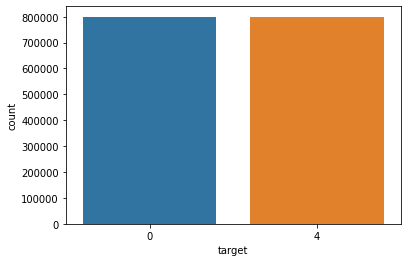

In [21]:
sns.countplot(data = data, x = 'target')

Wyświetl kilka losowych przykładów z każdej klasy:

In [22]:
data[data['target']== 0].sample(15)

,target,ids,date,flag,user,text
742966,0,2266703022,Sun Jun 21 08:57:45 PDT 2009,NO_QUERY,chaqueta,@natters1210 your avatar is a big x on my comp...
716869,0,2259827962,Sat Jun 20 18:13:42 PDT 2009,NO_QUERY,seylind,We won silver yesturday \/ pero sayang yung gold
790278,0,2325616986,Thu Jun 25 05:46:33 PDT 2009,NO_QUERY,JayLauretta,@jyeags Just saw this reply. $3.50 is a hell o...
184709,0,1967780992,Fri May 29 20:12:00 PDT 2009,NO_QUERY,gudrunhaider,Playing piano for a little while because soon ...
30431,0,1563765840,Mon Apr 20 00:10:14 PDT 2009,NO_QUERY,petpal102,depression sucks
684867,0,2250627604,Sat Jun 20 01:02:21 PDT 2009,NO_QUERY,SweetLovelyYJ,It is so................................. boring
128140,0,1834857319,Mon May 18 04:25:34 PDT 2009,NO_QUERY,davideggleton,"@Bdav me too, I only found out about it a few ..."
465577,0,2175380666,Mon Jun 15 00:49:43 PDT 2009,NO_QUERY,MarKusLambert,@mikalahgordon I wanna be there with you!! I ...
487009,0,2181873469,Mon Jun 15 12:24:52 PDT 2009,NO_QUERY,Abeillee,@RemiDanaeJ HEY YOU LOL. I can't beleive I joi...
669564,0,2246293761,Fri Jun 19 17:22:47 PDT 2009,NO_QUERY,iAmTarynItUp,@simplyminda so u either got the pic or NOT bi...


In [23]:
data[data['target']== 4].sample(9)

,target,ids,date,flag,user,text
958131,4,1825635881,Sun May 17 06:22:20 PDT 2009,NO_QUERY,checkerz_1220,"http://twitpic.com/5cwn5 - This was acting, ok..."
1484880,4,2067748748,Sun Jun 07 12:53:31 PDT 2009,NO_QUERY,BLACKMARS,see u later my friend !!!!
962010,4,1827199039,Sun May 17 10:12:09 PDT 2009,NO_QUERY,HayleyLovesNoel,@emzmccaw i think the lead singer Billie joe ...
1554292,4,2184831393,Mon Jun 15 16:29:10 PDT 2009,NO_QUERY,jaimekelley,i love you so freakin' much! i just wanna kiss...
1344507,4,2039885289,Thu Jun 04 23:03:29 PDT 2009,NO_QUERY,SunnySoPretty,Btw I Completed Day 3 w. No Meat
1380285,4,2052227289,Sat Jun 06 00:02:51 PDT 2009,NO_QUERY,NikkiBenz,@badartie thank u. I was crazy busy
1058482,4,1962940781,Fri May 29 11:57:33 PDT 2009,NO_QUERY,mudandgears,Is there anything better than a bike ride in t...
1199804,4,1985380597,Sun May 31 16:59:53 PDT 2009,NO_QUERY,jgreenler,@sylven OK. For tonight only. No hundred dolla...
1487630,4,2068315600,Sun Jun 07 13:52:28 PDT 2009,NO_QUERY,egg1111115,Everybody: follow @ExtraLives if you like vide...


# Preprocessing

Teraz jak wiemy z czym mamy do czynienia, zacznijmy od czyszczenia danych. Po pierwsze, skopiuj do nowej tabelki tylko kolumny `text` i `target`, a w kolumnie `target` zmień wartość 4 na 1. Można to zrobić metodą `replace` z parameterem `inplace` ustawionym na `True`.

In [26]:
df0 = data.copy()
df = df0.filter(['text','target'], axis=1)
df['target'] = df['target'].replace([4], 1)

In [30]:
#df = df0.filter(['text','target'], axis=1)
#
df

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,1
1599996,TheWDB.com - Very cool to hear old Walt interv...,1
1599997,Are you ready for your MoJo Makeover? Ask me f...,1
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1


Teraz zamień wszystkie teksty w kolumnie `text` na małe litery (metodą `str.lower()`). Użyj do tego metody `apply` na kolumnie `text`. Niestety metoda ta nie posiada atrybutu `inplace` więc należy ręcznie nadpisać kolumnę nowymi wartościami.

In [32]:
def lower(t):
  return str.lower(t)

df['lowtext'] = df['text'].apply(lower)

In [33]:
# na razie nie usuwam kolumny 'text' ale jesli zechcę to: df = df.drop('column_name', axis=1)

In [34]:
df

,text,target,lowtext
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,is upset that he can't update his Facebook by ...,0,is upset that he can't update his facebook by ...
2,@Kenichan I dived many times for the ball. Man...,0,@kenichan i dived many times for the ball. man...
3,my whole body feels itchy and like its on fire,0,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",0,"@nationwideclass no, it's not behaving at all...."
...,...,...,...
1599995,Just woke up. Having no school is the best fee...,1,just woke up. having no school is the best fee...
1599996,TheWDB.com - Very cool to hear old Walt interv...,1,thewdb.com - very cool to hear old walt interv...
1599997,Are you ready for your MoJo Makeover? Ask me f...,1,are you ready for your mojo makeover? ask me f...
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1,happy 38th birthday to my boo of alll time!!! ...


Teraz użyj biblioteki [re](https://docs.python.org/3/library/re.html) żeby usunąć z tekstu wszystkie URLe - np. wszystkie tokeny oddzielone spacją zaczynające się od `www.` albo `http(s)://`.

In [36]:
def resub(t):
  return re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', "", t)

df['lowtext'] = df['lowtext'].apply(resub)

df.head()

,text,target,lowtext
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,"@switchfoot - awww, that's a bummer. you sho..."
1,is upset that he can't update his Facebook by ...,0,is upset that he can't update his facebook by ...
2,@Kenichan I dived many times for the ball. Man...,0,@kenichan i dived many times for the ball. man...
3,my whole body feels itchy and like its on fire,0,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",0,"@nationwideclass no, it's not behaving at all...."


Teraz usuń wyrażeniami regularnymi wszystkie znaki z tekstu oprócz:
* liter alfabetu
* białych znaków (klasa `\s`)
* apostrofu `'` (chodzi o angielskie skracanie, np don't albo isn't)

https://realpython.com/regex-python/

initial string :  abcjw:, .@! eiw
final string abcjweiw


Następnie wczytamy model `en_core_web_md` z biblioteki spacy. Użyjemy do tego metody `spacy.load`, ale dodamy też atrybut `disable=['ner', 'parser']`. W następnej linii dopiszemy `nlp.add_pipe('sentencizer')`.

Usunięcie zbędnych pipelineów przyspieszy proces lematyzacji opisywany niżej.

In [38]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

Zanim się weźmiemy za lematyzację, usuniemy z tekstu wszystkie tzw. "stop words", czyli słowa o małej przydatności w procesie klasyfikacji.

Obejrzyj listę słów `nlp.Defaults.stop_words`.

In [39]:
stopwords = nlp.Defaults.stop_words
print(stopwords)

{'hers', 'take', 'eight', 'to', "'m", 'toward', 'over', 'various', 'neither', 'move', 'thereby', 'n‘t', 'all', 'back', "'s", 'down', 'in', 'her', 'hereafter', 'through', 'when', 'go', 'our', 'latterly', 'yourselves', 'us', 'will', 'just', 'but', 'last', '‘s', 'seem', 'indeed', 'during', 'never', 'were', 'anywhere', 'did', 'out', 'whatever', 'the', 'than', 'become', 'nothing', 'himself', 'such', 'could', 'former', 'should', 'meanwhile', 'no', 'above', 'or', 'nowhere', 'noone', 'either', 'fifteen', 'whence', 'being', 'bottom', 'unless', 'once', 'whose', 'while', 'with', 'none', '‘ve', 'other', 'everything', 'whereupon', 'seemed', 'somewhere', 'have', 'off', 'might', 'are', '‘ll', 'why', 'me', 'still', 'whither', "'ve", 'therefore', 'whom', 'next', 'top', 'please', 'whether', 'very', 'six', 'much', 'well', 'hundred', 'mostly', 'they', 'ever', 'yours', 'herein', 'has', 'throughout', 'own', 'wherever', 'nobody', 'been', 'used', 'regarding', 'doing', 'nine', 'nor', 'at', 'via', 'who', 'betwe

Teraz zrób funkcję do usuwania stopwords która bierze tekst i zwraca tekst z usuniętymi słowami z listy powyżej. Użyj metody `apply` do zastosowania tej funkcji na całym zbiorze danych - tak jak to robiliśmy dotąd.

https://medium.com/@yashj302/stopwords-nlp-python-4aa57dc492af

In [ ]:
#

cleanedtext = []
for item in nlp(text):
    if not item.is_stop:
        cleanedtext.append(item.text)
print(' '.join(cleanedtext))

Następny krok jest zbyt czasochłonny żeby go zastosować na lekcji na całym zbiorze danych. Wczytaj zatem 20 tysięcy próbek (po 10 tys. na klasę) do nowej tabelki:

Tokenizacja i lematyzacja w bibliotece spacy jest dosyć prostym procesem. Wystarczy przekazać tekst do modułu `nlp` czyli napisać `nlp(text)`. Zwróci nam to generator którego możemy przeiterować metodą `for` i dla każdego elementu (każdego wyrazu) zwrócić parametr `lemma_` (z podkreślikiem, żeby otrzymać string zamiast indeksu). Wszystkie lematy oczywiście należy połączyć spacjami z powrotem w tekst.

Użyj do tego metody `progress_apply` tak samo jako `apply` użyty powyżej.

## Chmury słów

Jak mamy oczyszczony tekst, możemy zwizualizować jego zawartość sprawdzając chmury słów. Użyjemy do tego biblioteki `WordCloud`. Do konstruktora podaj atrybuty `max_words = 1000`, `width = 1600`, `height = 800`, `collocations=False`, a potem użyj metody `generate` podając do niej tekst złączony z całego przelematyzowanego zbioru. Na koniec użyj metody `to_image()` żeby wyświetlić chmurę.

Zrób to osobno dla klasy negatywnej i pozytywnej. Jakie słowa tam widzisz? Czy są jakieś słowa które się pojawiają w obydwu klasach (może powinny trafić na listę stop-words)?

https://www.geeksforgeeks.org/generating-word-cloud-python/

In [ ]:
#
# Python program to generate WordCloud
 
# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
 
# Reads 'Youtube04-Eminem.csv' file
df = pd.read_csv(r"Youtube04-Eminem.csv", encoding ="latin-1")
 
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df.CONTENT:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Klasyfikacja

Podziel zbiór standardową metodą `train_test_split`: 10% test, 90% train. Użyj też stratyfikacji!

In [ ]:

dane.train_test_split(X = lowtext,
                      y = TemporaryWorkingDirectory,
                      test_size = 0.1,
                      stratify=y)

Teraz musimy wyciągnąć jakieś sensowne cechy z każdego elementu. Użyjemy do tego klasę `TfidfVectorizer`. Dodamy do konstruktora atrybut `max_features=500000` oraz `ngram_range=(1,2)` żeby wskazać że szukamy par wyrazów, a nie tylko unigramów.

Potem zastosuj metodę `fit` na zbiorze `X_train`.

Klasa ta najpierw szuka listy wyrazów (a raczej par) mających wysoką wartość według kryterium TF-IDF. Użyj metody `get_feature_names_out` żeby pobrać ich listę. Ile jest tych elementów?

Teraz zastosuj metodę `transform` na zbiorach `X_train` i `X_test`.

Jakie są rozmiary powstałych tablic?

Na szczęście, scikit-learn je zapisał automatycznie w formacie "sparse matrix" więc nie zajmują tak dużo pamięci.

Wypisz tablekę `X_train` metodą `print` żeby zobaczyć fragment jej zawartości.

Zobaczymy w ten sposób tylko wartości różne od 0.

## Właściwa klasyfikacja

Stwórz model `BernoulliNB`, czyli Naive Bayes - popularny do klayfikacji spamu! Użyj metody `fit` na danych traningowych, `predict` na testowych i `classification_report` żeby sprawdzić wynik.

Jeśli masz ochotę narysuj tez macierz konfuzji i wypróbuj inne klasyfikatory oraz metody ekstrakcji cech z biblioteki scikit-learn.